In [1]:
import os
import cv2
import numpy as np
import shutil
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [20]:
BASE_DIR = "SegmentedData"

PATH_FINAL_TEST_SOURCE = os.path.join("NIH-NLM-ThinBloodSmearsPf", "Point Set") 
POLYGON_SET_PATH  = os.path.join("NIH-NLM-ThinBloodSmearsPf", "Polygon Set")
POLYGON_DATA_DIR = os.path.join(BASE_DIR, "Polygon_Data")

# Create base structure
for split in ["Polygon_Data", "Final_Test"]:
        os.makedirs(os.path.join(BASE_DIR, split), exist_ok=True)

print(f"Initialized output structure at: {BASE_DIR}")

splits = ['Train', 'Val', 'Test']
modes = ['GT/black_background', 'GT/original_background', 'Seg/Watershed', 'Seg/Hough']

for split in splits:
    for mode in modes:
        os.makedirs(os.path.join(POLYGON_DATA_DIR, split, mode), exist_ok=True)

Initialized output structure at: SegmentedData


# Extract Segmented Cells from Images: Functions

In [22]:
def get_channel(img_rgb, mode='green'):
    """ CLAHE + Invert Green """
    if mode == 'green':
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        g_c = clahe.apply(img_rgb[:, :, 1])
        green_inverted = 255 - g_c
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        _, roi_mask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
        img_green = cv2.bitwise_and(green_inverted, green_inverted, mask=roi_mask)
        return img_green
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [23]:
def is_positive_label(label_str):
    lbl = label_str.lower().strip()
    if 'parasitized' in lbl: return True
    if 'infected' in lbl and 'un' not in lbl: return True
    return False

def parse_gt_points(filepath):
    """
    Parses GT file
    """
    points = []
    if not os.path.exists(filepath): return points
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 5: continue
                
                raw_label = parts[1].strip()
                
                try:
                    coords = [float(p) for p in parts[5:]]
                    
                    if len(coords) >= 2:
                        xs = coords[0::2]
                        ys = coords[1::2]
                        
                        center_x = sum(xs) / len(xs)
                        center_y = sum(ys) / len(ys)
                        
                        points.append({'x': center_x, 'y': center_y, 'label': raw_label})
                except ValueError:
                    continue
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
        
    return points

In [24]:
def get_watershed_candidates(img_rgb, params):
    img_proc = get_channel(img_rgb, mode='green')
    
    blur_ksize = params.get('blur_ksize', 0)
    morph_kernel_size = params.get('morph_kernel_size', 3)
    dist_mask_size = params.get('dist_mask_size', 5)
    dist_thresh_ratio = params.get('dist_thresh_ratio', 0.5)
    min_area = params.get('min_area', 50)
    
    if blur_ksize > 0:
        k = blur_ksize if blur_ksize % 2 != 0 else blur_ksize + 1
        img_input = cv2.GaussianBlur(img_proc, (k, k), 0)
    else:
        img_input = img_proc
        
    valid_pixels = img_input[img_input > 0]
    if len(valid_pixels) == 0: return []
    
    otsu_thresh, _ = cv2.threshold(valid_pixels, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary = cv2.threshold(img_input, otsu_thresh, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, dist_mask_size)
    
    if dist_transform.max() == 0: return []
    _, sure_fg = cv2.threshold(dist_transform, dist_thresh_ratio * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img_rgb, markers)
    
    unique, counts = np.unique(markers, return_counts=True)
    valid_labels = [l for l, c in zip(unique, counts) if l > 1 and c > min_area]
    candidates = []

    full_mask = np.isin(markers, valid_labels).astype(np.uint8) * 255
    contours, _ = cv2.findContours(full_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        cv2.drawContours(full_mask, [cnt], -1, 255, -1)
        x, y, w, h = cv2.boundingRect(cnt)
        candidates.append({'cnt': cnt, 'rect': (x, y, w, h)})
        
    return candidates

def get_hough_candidates(img_rgb, params):
    img_proc = get_channel(img_rgb, mode='green')
    
    blur_ksize = params.get('blur_ksize', 5)
    dp = params.get('dp', 1.2)
    minDist = params.get('minDist', 35)
    param1 = params.get('param1', 50)
    param2 = params.get('param2', 30)
    min_radius = params.get('min_radius', 15)
    max_radius = params.get('max_radius', 80)
    
    if blur_ksize > 0:
        k = blur_ksize if blur_ksize % 2 != 0 else blur_ksize + 1
        blur = cv2.medianBlur(img_proc, k)
    else:
        blur = img_proc
    
    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
        param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius
    )
    
    candidates = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for c in circles[0, :]:
            cx, cy, r = int(c[0]), int(c[1]), int(c[2])
            
            side = int(r * 2.2) 
            x = max(0, int(cx - side//2))
            y = max(0, int(cy - side//2))
            w, h = side, side
            
            theta = np.linspace(0, 2*np.pi, 20)
            cnt_x = cx + r * np.cos(theta)
            cnt_y = cy + r * np.sin(theta)
            cnt = np.column_stack((cnt_x, cnt_y)).astype(np.int32)
            
            candidates.append({'cnt': cnt, 'rect': (x, y, w, h)})
            
    return candidates

In [25]:
FINAL_CONFIG = {
    "Watershed": {
        "func": get_watershed_candidates, 
        "params": {"blur_ksize": 0, "dist_mask_size": 3, "dist_thresh_ratio": 0.2, "min_area": 75}
    },
    "Hough": {
        "func": get_hough_candidates, 
        "params": {"blur_ksize": 5, "param1": 50, "param2": 35, "min_radius": 50, "max_radius": 90}
    }
}

In [26]:
def process_dataset_structured(source_path, target_base_dir, patients_list, split_name=None):
    print(f"\nProcessing {split_name if split_name else 'Dataset'} from: {source_path}")
    total_p = len(patients_list)
    stats = {"Total": 0, "Images": 0}

    for i, patient_id in enumerate(patients_list):
        print(f"[{i+1}/{total_p}] Patient: {patient_id}" + " " * 20, end='\r')
        patient_path = os.path.join(source_path, patient_id)
        
        img_files = []
        for root, _, files in os.walk(patient_path):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_files.append(os.path.join(root, f))
        
        for img_path in img_files:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            
            parent_dir = os.path.dirname(img_path)
            gt_candidates = [
                os.path.join(parent_dir, img_name + ".txt"),
                os.path.join(parent_dir, "GT", img_name + ".txt"),
                os.path.join(patient_path, "GT", img_name + ".txt"),
                img_path.replace("Img", "GT").replace(os.path.splitext(img_path)[1], ".txt")
            ]
            gt_path = next((c for c in gt_candidates if os.path.exists(c)), None)
            if not gt_path: continue
            
            img = cv2.imread(img_path)
            if img is None: continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gt_points = parse_gt_points(gt_path)
            stats["Images"] += 1

            for method_name, config in FINAL_CONFIG.items():
                candidates = config['func'](img_rgb, config['params'])
                
                for idx, cand in enumerate(candidates):
                    cnt = cand['cnt']
                    x, y, w, h = cand['rect']
                    
                    labels_inside = [pt['label'] for pt in gt_points if cv2.pointPolygonTest(cnt, (pt['x'], pt['y']), False) >= 0]
                    if not labels_inside: continue
                    
                    unique_labels = set([l.strip() for l in labels_inside])
                    has_p = any(('parasitized' in l.lower() or ('infected' in l.lower() and 'un' not in l.lower())) for l in unique_labels)
                    
                    if has_p:
                        final_label = next(l for l in unique_labels if 'parasitized' in l.lower() or 'infected' in l.lower())
                    elif any('white' in l.lower() for l in unique_labels): 
                        final_label = "White_Blood_Cell"
                    elif any('uninfected' in l.lower() for l in unique_labels): 
                        final_label = "Uninfected"
                    else: 
                        final_label = list(unique_labels)[0]
                    
                    final_label = final_label.replace('"', '').strip()
                    
                    if split_name:
                        save_dir = os.path.join(target_base_dir, split_name, "Seg", method_name, patient_id, img_name, final_label)
                    else:
                        save_dir = os.path.join(target_base_dir, "Final_Test", method_name, patient_id, img_name, final_label)
                    
                    os.makedirs(save_dir, exist_ok=True)
                    
                    pad = 10
                    x1, y1 = max(0, x-pad), max(0, y-pad)
                    x2, y2 = min(img_rgb.shape[1], x+w+pad), min(img_rgb.shape[0], y+h+pad)
                    crop = img_rgb[y1:y2, x1:x2].copy()
                    
                    if "Watershed" in method_name:
                        mask_crop = np.zeros(crop.shape[:2], dtype=np.uint8)
                        cv2.drawContours(mask_crop, [cnt - [x1, y1]], -1, 255, -1)
                        mask_crop = cv2.morphologyEx(mask_crop, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
                        crop = cv2.bitwise_and(crop, crop, mask=mask_crop)
                    
                    cv2.imwrite(os.path.join(save_dir, f"cell_{idx}.jpg"), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))
                    stats["Total"] += 1
                        
    print(f"\nProcessed {stats['Images']} images, saved {stats['Total']} cells.")

In [43]:
#Processing Point Set (Final Boss)
final_test_patients = [p for p in os.listdir(PATH_FINAL_TEST_SOURCE) 
                       if os.path.isdir(os.path.join(PATH_FINAL_TEST_SOURCE, p))]

process_dataset_structured(
    source_path=PATH_FINAL_TEST_SOURCE, 
    target_base_dir=os.path.join(BASE_DIR, "Final_Test"), 
    patients_list=final_test_patients,
    split_name=None
)


Processing Dataset from: NIH-NLM-ThinBloodSmearsPf\Point Set
[160/160] Patient: 380C241NThinF                                    
Processed 800 images, saved 344175 cells.


# Stratification

In [ ]:
def get_gt_counts(filepath):
    n_inf, n_uninf = 0, 0
    if not os.path.exists(filepath): return 0, 0
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 2: continue
                lbl = parts[1].strip().lower()
                if 'parasitized' in lbl or ('infected' in lbl and 'un' not in lbl):
                    n_inf += 1
                elif 'uninfected' in lbl:
                    n_uninf += 1
    except: pass
    return n_inf, n_uninf

In [4]:
patient_stats = []
patients = [d for d in os.listdir(POLYGON_SET_PATH) if os.path.isdir(os.path.join(POLYGON_SET_PATH, d))]

for patient_id in patients:
    gt_dir = os.path.join(POLYGON_SET_PATH, patient_id, "GT")
    total_inf, total_uninf = 0, 0
    
    if os.path.exists(gt_dir):
        gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.txt')]
        for gt_file in gt_files:
            inf, uninf = get_gt_counts(os.path.join(gt_dir, gt_file))
            total_inf += inf
            total_uninf += uninf
            
    total_cells = total_inf + total_uninf
    parasitemia = (total_inf / total_cells) if total_cells > 0 else 0
    
    patient_stats.append({
        'patient_id': patient_id,
        'infected': total_inf,
        'uninfected': total_uninf,
        'total': total_cells,
        'parasitemia': parasitemia
    })

df_patients = pd.DataFrame(patient_stats)

In [5]:
df_patients = df_patients.sort_values('parasitemia').reset_index(drop=True)
df_patients['bin'] = pd.qcut(df_patients['parasitemia'], q=5, labels=False, duplicates='drop')

train_patients, temp_patients = train_test_split(
    df_patients, 
    train_size=20, 
    stratify=df_patients['bin'], 
    random_state=42
)

val_patients, test_patients = train_test_split(
    temp_patients, 
    train_size=5, 
    stratify=temp_patients['bin'], 
    random_state=42
)

split_map = {}
for pid in train_patients['patient_id']: split_map[pid] = 'Train'
for pid in val_patients['patient_id']: split_map[pid] = 'Val'
for pid in test_patients['patient_id']: split_map[pid] = 'Test'

print(f"Split Summary: Train: {len(train_patients)}, Val: {len(val_patients)}, Test: {len(test_patients)}")

Split Summary: Train: 20, Val: 5, Test: 8


In [27]:
#Processing Polygon Set with Stratified Splits
for split in ['Train', 'Val', 'Test']:
    p_list = [pid for pid, s in split_map.items() if s == split]
    
    if p_list:
        process_dataset_structured(
            source_path=POLYGON_SET_PATH, 
            target_base_dir=POLYGON_DATA_DIR, 
            patients_list=p_list, 
            split_name=split
        )


Processing Train from: NIH-NLM-ThinBloodSmearsPf\Polygon Set
[20/20] Patient: 146C47P8thin_Original_Motic                    
Processed 200 images, saved 42499 cells.

Processing Val from: NIH-NLM-ThinBloodSmearsPf\Polygon Set
[5/5] Patient: 212C71P32_ThinF                      
Processed 50 images, saved 10638 cells.

Processing Test from: NIH-NLM-ThinBloodSmearsPf\Polygon Set
[8/8] Patient: 150C49P10thinF                     
Processed 80 images, saved 17204 cells.


# Test the Labeling Process

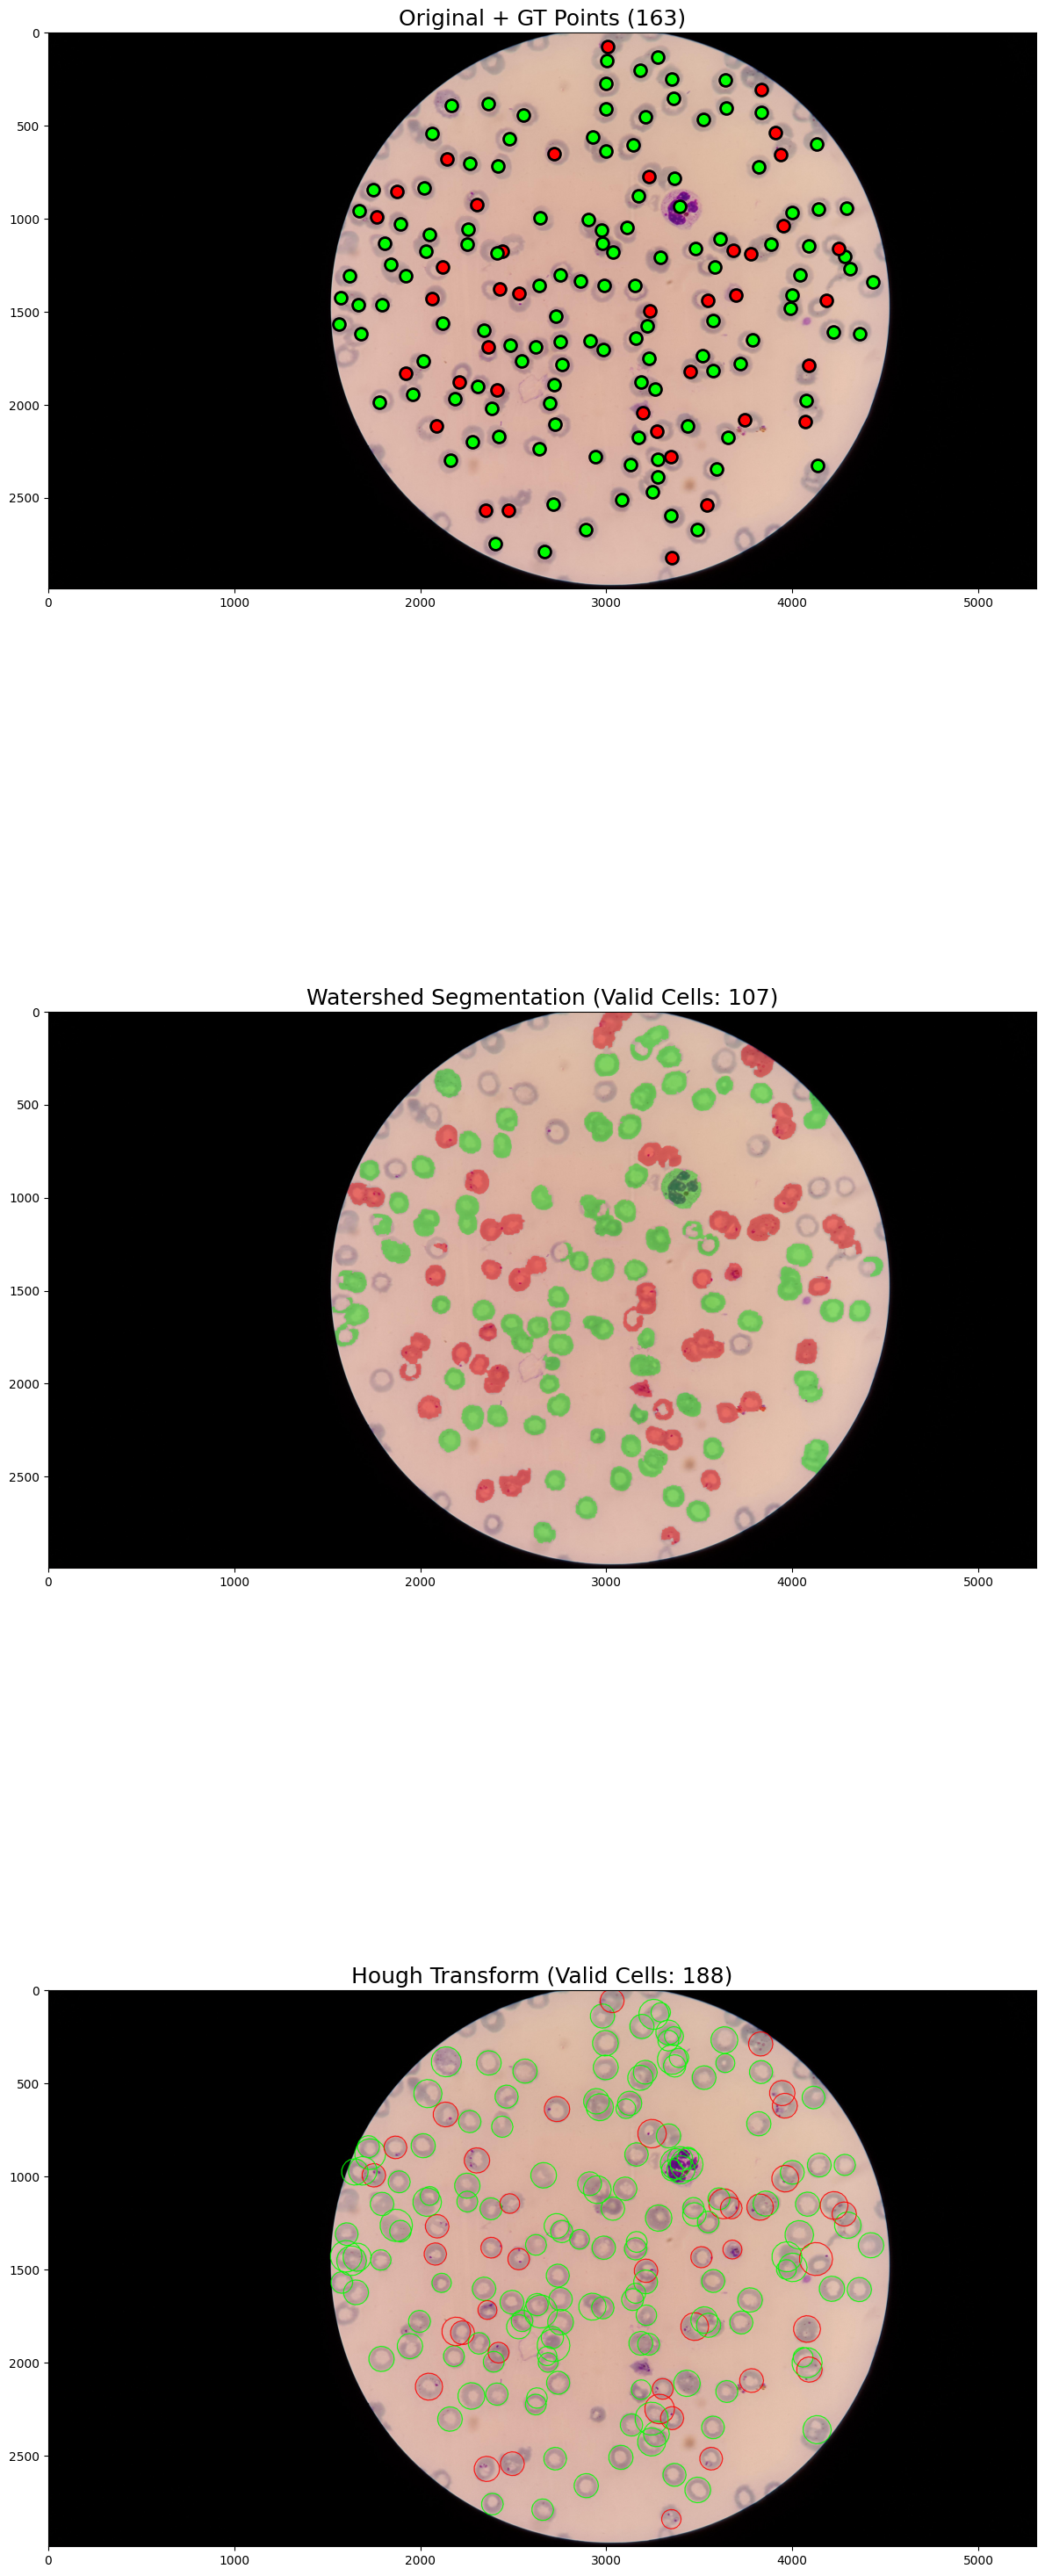

In [ ]:
ROOT_DIR = "." 

IMG_REL_PATH = os.path.join("NIH-NLM-ThinBloodSmearsPf", "Point Set", "143C39P4thinF_original", "Img", "IMG_20150622_105102.jpg")
GT_REL_PATH  = os.path.join("NIH-NLM-ThinBloodSmearsPf", "Point Set", "143C39P4thinF_original", "GT", "IMG_20150622_105102.txt")
IMG_PATH = os.path.join(ROOT_DIR, IMG_REL_PATH)
GT_PATH = os.path.join(ROOT_DIR, GT_REL_PATH)


if not os.path.exists(IMG_PATH):
    print(f"ERROR: Image not found at {IMG_PATH}")
else:
    img = cv2.imread(IMG_PATH)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    points = parse_gt_points(GT_PATH)
    
    ws_candidates = FINAL_CONFIG['Watershed']['func'](img_rgb, FINAL_CONFIG['Watershed']['params'])
    hough_candidates = FINAL_CONFIG['Hough']['func'](img_rgb, FINAL_CONFIG['Hough']['params'])
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 36))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title(f"Original + GT Points ({len(points)})", fontsize=18)
    for p in points:
        color = 'red' if is_positive_label(p['label']) else 'lime'
        axes[0].scatter(p['x'], p['y'], c=color, s=100, edgecolors='black', linewidth=2)

    def visualize_clean(ax, candidates, title, mode='overlay'):
        vis_img = img_rgb.copy()
        if mode == 'overlay':
            final_img = img_rgb.copy()
        else:
            final_img = img_rgb.copy()
            
        valid_count = 0
        
        for cand in candidates:
            cnt = cand['cnt']
            
            labels_inside = []
            for p in points:
                if cv2.pointPolygonTest(cnt, (p['x'], p['y']), False) >= 0:
                    labels_inside.append(p['label'])

            if len(labels_inside) == 0:
                continue 
            
            valid_count += 1
            
            has_parasite = any(is_positive_label(l) for l in labels_inside)
            if has_parasite:
                color = (255, 0, 0) # Red (Infected/Parasitized)
            else:
                color = (0, 255, 0) # Green (Uninfected/WBC)
            
            if mode == 'overlay':
                cv2.drawContours(vis_img, [cnt], -1, color, -1)
            else:
                cv2.drawContours(final_img, [cnt], -1, color, 4)

        if mode == 'overlay':
            final_img = cv2.addWeighted(vis_img, 0.4, img_rgb, 0.6, 0)
            
        ax.imshow(final_img)
        ax.set_title(f"{title} (Valid Cells: {valid_count})", fontsize=18)

    visualize_clean(axes[1], ws_candidates, "Watershed Segmentation", mode='overlay')
    visualize_clean(axes[2], hough_candidates, "Hough Transform", mode='outline')

    plt.tight_layout()
    plt.show()

# Parasitemia GT and Expected

In [29]:
def count_folder_cells(image_folder):
    n_inf, n_uninf = 0, 0
    for name in ['Parasitized', 'Infected', 'Infected_RBC']:
        p_path = os.path.join(image_folder, name)
        if os.path.exists(p_path):
            n_inf += len([f for f in os.listdir(p_path) if f.endswith('.jpg')])
            
    u_path = os.path.join(image_folder, 'Uninfected')
    if os.path.exists(u_path):
        n_uninf += len([f for f in os.listdir(u_path) if f.endswith('.jpg')])
    return n_inf, n_uninf

In [39]:
data = []

configs = [
    ('Polygon_Train', os.path.join(POLYGON_DATA_DIR, 'Train', 'Seg'), POLYGON_SET_PATH),
    ('Polygon_Val',   os.path.join(POLYGON_DATA_DIR, 'Val', 'Seg'),   POLYGON_SET_PATH),
    ('Polygon_Test',  os.path.join(POLYGON_DATA_DIR, 'Test', 'Seg'),  POLYGON_SET_PATH),
    ('Final_Boss',    os.path.join(BASE_DIR, 'Final_Test', 'Final_Boss'), PATH_FINAL_TEST_SOURCE)
]

for split_name, seg_root, gt_root in configs:
    if not os.path.exists(seg_root): 
        continue
        
    for method in ['Watershed', 'Hough']:
        method_path = os.path.join(seg_root, method)
        if not os.path.exists(method_path): 
            continue
        
        patients = [p for p in os.listdir(method_path) if os.path.isdir(os.path.join(method_path, p))]
        
        for patient in patients:
            pat_path = os.path.join(method_path, patient)
            
            for img_name in os.listdir(pat_path):
                img_folder = os.path.join(pat_path, img_name)
                if not os.path.isdir(img_folder): 
                    continue
                
                est_inf, est_un = count_folder_cells(img_folder)
                est_total = est_inf + est_un
                est_rate = (est_inf / est_total * 100) if est_total > 0 else 0
                
                gt_path = os.path.join(gt_root, patient, "GT", img_name + ".txt")
                
                if not os.path.exists(gt_path): 
                    continue
                
                gt_inf, gt_un = get_gt_counts(gt_path)
                gt_total = gt_inf + gt_un
                gt_rate = (gt_inf / gt_total * 100) if gt_total > 0 else 0
                
                data.append({
                    'Split': split_name, 
                    'Method': method, 
                    'Patient': patient,
                    'Image': img_name,
                    '%, GT': gt_rate, 
                    '%, Estimated': est_rate,
                    'Cells_Found': est_total,
                    'Cells_GT': gt_total
                })

df = pd.DataFrame(data)

C:\Users\Polina\AppData\Local\Temp\ipykernel_20212\320307684.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


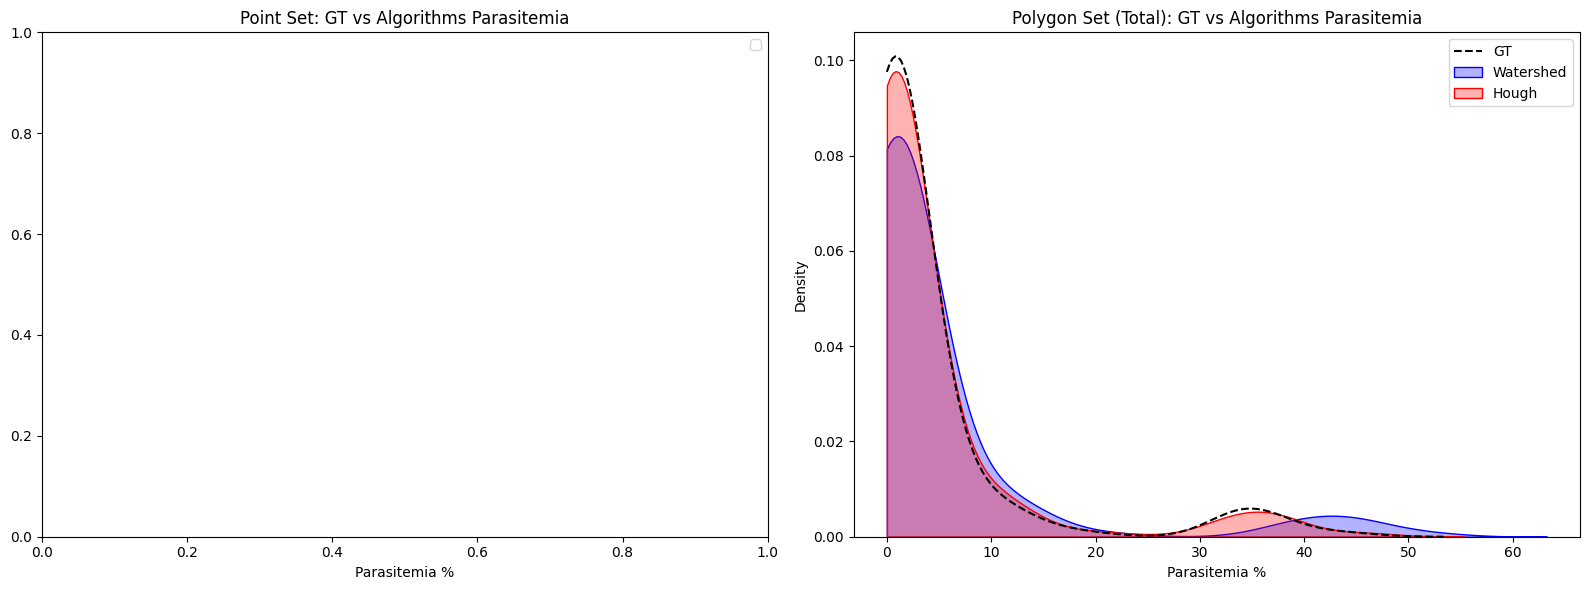

In [31]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
pt_df = df[df['Split'] == 'Final_Boss']
if not pt_df.empty:
    sns.kdeplot(data=pt_df[pt_df['Method'] == 'Watershed'], x='%, GT', label='GT', color='black', linestyle='--', clip=(0, 100))
    sns.kdeplot(data=pt_df[pt_df['Method'] == 'Watershed'], x='%, Estimated', label='Watershed', fill=True, color='blue', alpha=0.3, clip=(0, 100))
    sns.kdeplot(data=pt_df[pt_df['Method'] == 'Hough'], x='%, Estimated', label='Hough', fill=True, color='red', alpha=0.3, clip=(0, 100))
plt.title("Point Set: GT vs Algorithms Parasitemia")
plt.xlabel("Parasitemia %")
plt.legend()

plt.subplot(1, 2, 2)
poly_total_df = df[df['Split'].str.startswith('Polygon')]
if not poly_total_df.empty:
    sns.kdeplot(data=poly_total_df[poly_total_df['Method'] == 'Watershed'], x='%, GT', label='GT', color='black', linestyle='--', clip=(0, 100))
    sns.kdeplot(data=poly_total_df[poly_total_df['Method'] == 'Watershed'], x='%, Estimated', label='Watershed', fill=True, color='blue', alpha=0.3, clip=(0, 100))
    sns.kdeplot(data=poly_total_df[poly_total_df['Method'] == 'Hough'], x='%, Estimated', label='Hough', fill=True, color='red', alpha=0.3, clip=(0, 100))
plt.title("Polygon Set (Total): GT vs Algorithms Parasitemia")
plt.xlabel("Parasitemia %")
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Polina\AppData\Local\Temp\ipykernel_20212\3029624776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Split', y='%, GT', palette="Set2")


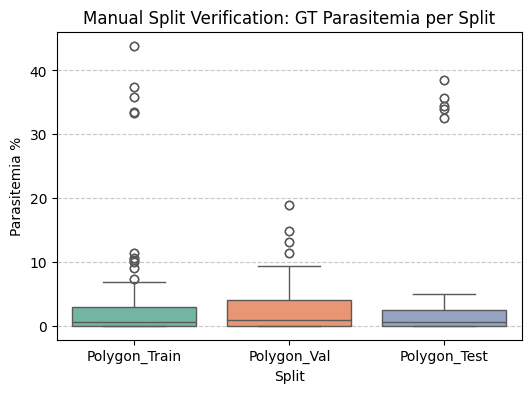

New Median Statistics per Split:
Split
Polygon_Test     0.489569
Polygon_Train    0.637356
Polygon_Val      0.925926
Name: %, GT, dtype: float64


In [41]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Split', y='%, GT', palette="Set2")
#sns.stripplot(data=df, x='Split', y='%, GT', color="black", alpha=0.3)
plt.title("Manual Split Verification: GT Parasitemia per Split")
plt.ylabel("Parasitemia %")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("New Median Statistics per Split:")
print(df.groupby('Split')['%, GT'].median())

# GT cells generation

In [9]:
def parse_gt_file(filepath):
    polygons = []
    if not os.path.exists(filepath):
        return polygons
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 5: continue
                
                label = parts[1].strip()
                if 'Uninfected' in label: label = 'Uninfected'
                elif 'Parasitized' in label or 'Infected' in label: label = 'Parasitized'
                elif 'WBC' in label or 'White_Blood_Cell' in label: label = 'WBC'
                
                coords = np.array([float(x) for x in parts[5:]]).reshape(-1, 2)
                polygons.append({'label': label, 'points': coords.astype(np.int32)})
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")
    return polygons

def get_safe_crop(img, x1, y1, x2, y2):
    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    return img[y1:y2, x1:x2]

In [21]:
PADDING = 5
total_patients = len(split_map)

for idx, (patient_id, split) in enumerate(split_map.items(), 1):
    img_dir = os.path.join(POLYGON_SET_PATH, patient_id, "Img")
    gt_dir = os.path.join(POLYGON_SET_PATH, patient_id, "GT")
    
    print(f"[{idx}/{total_patients}] Processing {split} set | Patient: {patient_id}")
    
    if not os.path.exists(img_dir) or not os.path.exists(gt_dir):
        continue
        
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_name in img_files:
        img_path = os.path.join(img_dir, img_name)
        img_stem = os.path.splitext(img_name)[0]
        gt_path = os.path.join(gt_dir, img_stem + ".txt")
        if not os.path.exists(gt_path): continue
            
        image = cv2.imread(img_path)
        if image is None: continue
        
        polygons = parse_gt_file(gt_path)
        
        for i, poly in enumerate(polygons):
            label = poly['label']
            pts = poly['points']
            x, y, w, h = cv2.boundingRect(pts)
            
            x1_pad, y1_pad = x - PADDING, y - PADDING
            x2_pad, y2_pad = x + w + PADDING, y + h + PADDING
            
            # Original Background Mode
            save_path_orig = os.path.join(POLYGON_DATA_DIR, split, "GT/original_background", patient_id, img_stem, label, f"{img_stem}_c{i}.jpg")
            os.makedirs(os.path.dirname(save_path_orig), exist_ok=True)
            crop_orig = get_safe_crop(image, x1_pad, y1_pad, x2_pad, y2_pad)
            cv2.imwrite(save_path_orig, crop_orig)
            
            # Black Background Mode
            save_path_black = os.path.join(POLYGON_DATA_DIR, split, "GT/black_background", patient_id, img_stem, label, f"{img_stem}_c{i}.jpg")
            os.makedirs(os.path.dirname(save_path_black), exist_ok=True)
            
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [pts], 255)
            masked_img = cv2.bitwise_and(image, image, mask=mask)
            crop_black = get_safe_crop(masked_img, x1_pad, y1_pad, x2_pad, y2_pad)
            cv2.imwrite(save_path_black, crop_black)

[1/33] Processing Train set | Patient: 323C231ThinF
[2/33] Processing Train set | Patient: 208C67P28N_ThinF
[3/33] Processing Train set | Patient: 228C86P47ThinF
[4/33] Processing Train set | Patient: 343C160P121ThinF
[5/33] Processing Train set | Patient: 270C122P83ThinF
[6/33] Processing Train set | Patient: 354C169P130ThinF
[7/33] Processing Train set | Patient: 372C187P148NThinF
[8/33] Processing Train set | Patient: 276C128P89ThinF
[9/33] Processing Train set | Patient: 302C210ThinF
[10/33] Processing Train set | Patient: 247C99P60ThinF
[11/33] Processing Train set | Patient: 158C57P18thinF
[12/33] Processing Train set | Patient: 377C238NThinF
[13/33] Processing Train set | Patient: 318C226ThinF
[14/33] Processing Train set | Patient: 142C38P3thinF_original
[15/33] Processing Train set | Patient: 244C7NthinF
[16/33] Processing Train set | Patient: 153C52P13thinF
[17/33] Processing Train set | Patient: 231C89P50ThinF
[18/33] Processing Train set | Patient: 274C126P87ThinF
[19/33] P